# Oasis model for Guadaloupe

#### Author: 
Silvia Bertelli

#### Date 
27th October 2020
    
#### Decription:
Jupyter notebook for running the Oasis model:
- estimates the windfiled using the STORM DATASET;
- adopted the GAR exposures files ad convert them into the OED format;
- convert the GAR vulnerability functions into the oasis format;

## 1 Case study

This jupyter notebook build and run an oasis model for Guadaloupe (GLP), which is located (WGS84):

In [1]:
latitude = 16.1730949
longitude = -61.4054001

The projected coordinate system for the area is: 

In [2]:
projectedsystem = "EPSG:2970"

Please, check here the reference for the adopted coordinate system: https://epsg.io/2970 

Please, specify a buffer radius [m] of the extent of the administrative bundaries in order to define the assessed area

In [3]:
radiusbuffer = 10000

Let's define the resolution of a grid through the following width and lenght values [m]; for this model, the grid is a simple uniform grid in squares.

In [4]:
res_width = 10000
res_height = 10000

Please, select a distance [km] (estimated from the centroid of the country) and wind category to select events from the STORM dataset:

In [7]:
distance_wind = 25
cat_wind = 4

## 2 Python code set up

In [8]:
%config IPCompleter.greedy=True


 ### 2.1 Libraries

In [11]:
import os
import sys
from pathlib import Path
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import math
import json
import seaborn as sns
import folium
from shapely.geometry import Polygon, MultiPoint, Point, box
from descartes import PolygonPatch
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.offsetbox import AnchoredText

Let's call the python functions for the windstorm calculations and to convert files to the Oasis input format

In [12]:
import oasismodel_functions as omf

 ### 2.2 References

Let's check which is the current working directory:

In [13]:
print(os.getcwd()) #this is my current working directory

/home/macab/OasisEvaluation/TestOasisEvaluation_GLP/Oasis_GLP/jupyter


Set this folder as the current working directory. You may want to comment (#) the following block if the two folders corresponds already:

In [14]:
#PACKAGE_DIR = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
#print("Current working directory is:" + PACKAGE_DIR)
#sys.path.append(PACKAGE_DIR)
#FILE_DIR = os.path.dirname('__file__')
#FILE_DATA_DIR = os.path.join(TEST_DIR, 'inputs/')

### 2.3 Input data folder

In [15]:
admin = '../model_data/admin/gadm36_GLP_0.shp'
gar = '../model_data/gar/lac_glp.shp'
intensity_dic = '../model_data/PiWind/intensity_bin_dict.csv'
damage_dic = '../model_data/PiWind/damage_bin_dict.csv'
fb_df_vf = '../model_data/vulnerability/GLP_Vulnerability_uniquevaluestest.csv' # vulnerability database 
fp_gar_dat = '../model_data/vulnerability/VulWdLAC.dat'

### 2.4 Output data folder

The script produces the following shapefiles:

In [16]:
fp_grid = '../tests/outputs/shp/grid.shp'
fp_wind = '../tests/outputs/shp/wind_dataset.shp'

and the following csv files:

In [17]:
fp_areaperil = '../keys_data/PiWind/areaperil_dict.csv'
fp_events = '../model_data/PiWind/events_p.csv'
fp_occurrence ='../model_data/PiWind/occurrence_lt.csv'
fp_footprint = '../model_data/PiWind/footprint.csv'
fp_vf_dic = '../keys_data/PiWind/vulnerability_dict.csv'
fp_vulnerability = '../model_data/PiWind/vulnerability.csv'
fp_exp2 = '../tests/inputs/SourceLocOED.csv'

fp_storm_csv = '../model_data/storm/STORM_DATA_IBTRACS_NA.csv'

path_vf = 'outputs/vulnerability_functions/{}.csv' #chech this
fp_vf_by_name = '../model_data/vulnerability/vf_by_name/{}.csv'
path_vf_out = '../tests/outputs/vulnerability/'

## 3 Assessed area

Load the administrative boundaries from the GADM shapefile:

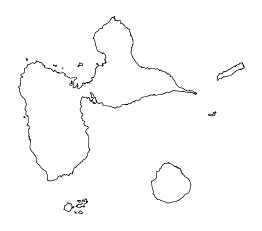

In [18]:
gdf_admin = omf.get_admin(admin, projected_crs = projectedsystem)

Buffer the administrative bundaries in order to define a larger area to be assessed:

In [19]:
gdf_admin_buffer = omf.buffer_grid(gdf_admin, radius = radiusbuffer)

and draw a grid over the assessed area:

In [20]:
gdf_grid = omf.get_grid(gdf_admin_buffer, height=res_height, width=res_width, projected_crs = projectedsystem, fp_grid = fp_grid)
print(" A shapefile of the grid has been saved into " + str(fp_grid))

 A shapefile of the grid has been saved into ../tests/outputs/shp/grid.shp


Now, let's determine the centroids and the vertices of this grid:

In [21]:
gdf_centroids = omf.get_grid_centroid(gdf_grid, projected_crs = projectedsystem)
gdf_vertices = omf.get_grid_vertices(gdf_grid,projected_crs = projectedsystem)

Convert the grid into the oasis format and save it as csv file (TODO: convert the coverage into a list at the top of the notebook and loop through them)

In [22]:
area_peril_df1 = omf.convert_to_oasis_areaperil(gdf_vertices, peril ='WTC', coverage = 1)
area_peril_df2 = omf.convert_to_oasis_areaperil(gdf_vertices, peril ='WTC', coverage = 3)
frames_areaperil = [area_peril_df1, area_peril_df2] #add here all the areaperils dataframes (we have different df as we have different coverages and perils)
area_peril_dictionary = omf.concatenate_df_areaperil(frames_areaperil, fp_areaperil)
print(" A csv of the area_peril_dictionary has been saved into " + str(fp_areaperil))

 A csv of the area_peril_dictionary has been saved into ../keys_data/PiWind/areaperil_dict.csv


Lets have a look at the model grid data contained in the Area Peril dictionary file. 
Note that the dictionary is only meta-data, and not required for model execution.

In [23]:
area_peril_dictionary.head()

,PERIL_ID,COVERAGE_TYPE,LON1,LAT1,LON2,LAT2,LON3,LAT3,LON4,LAT4,AREA_PERIL_ID
0,WTC,1,-61.901838,16.608005,-61.808102,16.607489,-61.808657,16.517109,-61.902349,16.517622,1
1,WTC,1,-61.902349,16.517622,-61.808657,16.517109,-61.809209,16.426728,-61.902858,16.427238,2
2,WTC,1,-61.902858,16.427238,-61.809209,16.426728,-61.809758,16.336346,-61.903363,16.336853,3
3,WTC,1,-61.903363,16.336853,-61.809758,16.336346,-61.810303,16.245963,-61.903865,16.246467,4
4,WTC,1,-61.903865,16.246467,-61.810303,16.245963,-61.810844,16.155580,-61.904364,16.156081,5


Lets plot the area peril cells on a map

In [24]:
m = omf.areapeeril_map(area_peril_dictionary,latitude, longitude)

In [25]:
%%HTML
<iframe width="100%" height=350 src="extent_map.html"></iframe>

## 4 Windfield estimation

### 4.1 Selection of events from the STORM dataset

Let's load the STORM dataset and select events based on the distance and category of the event:

In [26]:
df_storm = omf.load_multiple_STORM(gdf_admin, distance_wind, cat_wind, fp_storm_csv) 
df_storm.info()
print(" A csv of the selected windtrack has been saved into " + str(fp_storm_csv))

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2733 entries, 13550 to 337481
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ID_event  2733 non-null   object  
 1   Year      2733 non-null   int64   
 2   Month     2733 non-null   int64   
 3   TimeStep  2733 non-null   float64 
 4   Lat       2733 non-null   float64 
 5   Lon       2733 non-null   float64 
 6   Vmax_ms   2733 non-null   float64 
 7   RMW_km    2733 non-null   float64 
 8   category  2733 non-null   int64   
 9   r_km      2733 non-null   float64 
 10  source    2733 non-null   object  
 11  geometry  2733 non-null   geometry
dtypes: float64(6), geometry(1), int64(3), object(2)
memory usage: 277.6+ KB
 A csv of the selected windtrack has been saved into ../model_data/storm/STORM_DATA_IBTRACS_NA.csv


Estimate the B-shape parameter:

In [27]:
df_windtrack = omf.STORM_analysis(df_storm)
df_windtrack.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2733 entries, 13550 to 337481
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ID_event  2733 non-null   object  
 1   Year      2733 non-null   int64   
 2   Month     2733 non-null   int64   
 3   TimeStep  2733 non-null   float64 
 4   Lat       2733 non-null   float64 
 5   Lon       2733 non-null   float64 
 6   Vmax_ms   2733 non-null   float64 
 7   RMW_km    2733 non-null   float64 
 8   category  2733 non-null   int64   
 9   source    2733 non-null   object  
 10  geometry  2733 non-null   geometry
 11  B         2733 non-null   float64 
dtypes: float64(6), geometry(1), int64(3), object(2)
memory usage: 277.6+ KB


### 4.2 Events

Let's check the number of events that have been selected:

In [28]:
list_events = omf.unique_events(df_windtrack)

and convert them into a shapefile:

In [29]:
df_wind = omf.merge_unique_events_windtrack(list_events, df_windtrack, fp_wind)
print(" A shapefile of the selected events has been saved into " + str(fp_wind))

 A shapefile of the selected events has been saved into ../tests/outputs/shp/wind_dataset.shp


Then, convert the list of events into the oasis format:

In [30]:
df_oasis_events = omf.oasis_events(list_events, fp_events)
df_oasis_events.head()
print(" A csv of events dataframe in the oasis format has been saved into " + str(fp_events))

 A csv of events dataframe in the oasis format has been saved into ../model_data/PiWind/events_p.csv


### 4.3 Occurence

Let's have a look at the data contained in the occurence dataframe:

In [31]:
df_oasis_occurence = omf.oasis_occurence(list_events, fp_occurrence)
df_oasis_occurence.head()
print(" A csv of the occurence dataframe in the oasis format has been saved into " + str(fp_occurrence))

 A csv of the occurence dataframe in the oasis format has been saved into ../model_data/PiWind/occurrence_lt.csv


### 4.4 Intensity

Lets have a look at the data contained in the Intensity Bin dictionary file. 
Note that the dictionary is only meta-data, and not required for model execution.

In [32]:
intensity_bin_dictionary = omf.load_intensity(intensity_dic) #TODO: create the dataframe base on the windtrack dataframe
print(intensity_bin_dictionary.head())

   bin_index  bin_from  bin_to  interpolation  interval_type
0          1      37.5    42.5             40           1202
1          2      42.5    47.5             45           1202
2          3      47.5    52.5             50           1202
3          4      52.5    57.5             55           1202
4          5      57.5    62.5             60           1202


### 4.5 Footprints

In [33]:
df_merge = omf.merge_wind_w_grid(df_wind, gdf_centroids)

In [34]:
df_groupby = omf.groupby_grid(df_merge)

In [35]:
df_lookup = omf.intensity_lookup(intensity_bin_dictionary, df_groupby)

Lets have a look at the data contained in the footprint file. 

In [36]:
footprints = omf.get_footprint(df_lookup, fp_footprint)
footprints.head()
print(" A csv of the occurence dataframe in the oasis format has been saved into " + str(fp_footprint))

 A csv of the occurence dataframe in the oasis format has been saved into ../model_data/PiWind/footprint.csv


Lets visualize the first 5 event footprints.

<ipython-input-37-b848c9212b59>:46: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid[0].cax.colorbar(im)
/home/macab/oasis_evaluation/lib/python3.8/site-packages/mpl_toolkits/axes_grid1/axes_grid.py:46: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


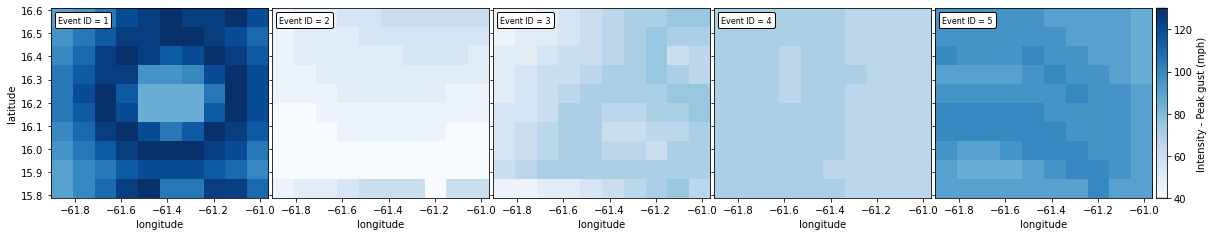

In [37]:
area_peril_dictionary['gridcell'] = area_peril_dictionary['AREA_PERIL_ID'].apply(
    lambda ap: str(int((ap-1)/10)+1)+"-"+str(ap-(int((ap-1)/10))*10))

footprints_with_hazard = footprints.merge(
    intensity_bin_dictionary, how='inner', 
    left_on='intensity_bin_id', right_on='bin_index').merge(
    area_peril_dictionary, how='inner', 
    left_on='areaperil_id', right_on='AREA_PERIL_ID')

footprints_with_hazard = footprints_with_hazard[footprints_with_hazard['PERIL_ID']=='WTC']
footprints_with_hazard = footprints_with_hazard[footprints_with_hazard['COVERAGE_TYPE']==1]

fig = plt.figure(figsize=(20,10))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 5),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

vmin = min(footprints_with_hazard.interpolation)
vmax = max(footprints_with_hazard.interpolation)
for idx, ax in enumerate(grid):
    a = np.zeros([10, 10])
    for __, row in footprints_with_hazard[footprints_with_hazard.event_id == idx+1].iterrows():
        i, j = row.gridcell.split('-')
        a[10-int(i), int(j)-1] = row.interpolation
    im = ax.imshow(a, cmap=plt.cm.get_cmap('Blues'), vmin=vmin, vmax=vmax,
                   extent=(
                       min(area_peril_dictionary.lon), max(area_peril_dictionary.lon), 
                       min(area_peril_dictionary.lat), max(area_peril_dictionary.lat)))
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    at = AnchoredText(
        "Event ID = {}".format(idx + 1),
        prop=dict(size=8),
        frameon=True,
        loc=2,
    )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

grid[0].cax.colorbar(im)
cax = grid.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text("Intensity - Peak gust (mph)")

plt.show()

## 5 Vulnerability assessment

### 5.1 Damage

Lets have a look at the data contained in the Damage Bin dictionary file. 
Note that the dictionary is required for model execution.

In [38]:
damage_bin_dictionary = omf.load_damage_dic(damage_dic)
damage_bin_dictionary.head()

,bin_index,bin_from,bin_to,interpolation,interval_type
0,1,0.0,0.0,0.00,1203
1,2,0.0,0.1,0.05,1200
2,3,0.1,0.2,0.15,1202
3,4,0.2,0.3,0.25,1202
4,5,0.3,0.4,0.35,1202


### 5.2 Vulnerability Database

Load the vulnerability dataframe and save each road separately:

In [39]:
df_vf = omf.load_vf(fb_df_vf, fp_vf_by_name)

Plot each vulnerability function:

In [40]:
df_glp_vf_1 = omf.plot_multi_vf(path_vf_out)

### 5.3 Vulnerability dictionary

Let's have a look at the gar vulnerability dat file

In [41]:
df_gar = omf.read_gar_vf(fp_gar_dat)
df_gar.head()

,GAR_vf,StructuralPeriod,FileName
0,Reg2_Dev22_Hz3_Cpx1_beds_priv_A_nr,1,AD1L_M(km_h).fvu
1,Reg2_Dev22_Hz3_Cpx1_beds_priv_C_nr,1,C1M_M(km_h).fvu
2,Reg2_Dev22_Hz3_Cpx1_beds_priv_UFB_nr,1,URML_M(km_h).fvu
3,Reg2_Dev22_Hz3_Cpx1_beds_priv_W_nr,1,W1_M(km_h).fvu
4,Reg2_Dev22_Hz3_Cpx1_beds_pub_A_nr,1,AD1L_M(km_h).fvu


Let's create a dictionary file to link the vulnerability database with the gar dat file:

In [42]:
gar_dictionary = omf.gar_dict(df_gar, df_vf)
gar_dictionary.head()

,GAR_vf,StructuralPeriod,FileName,OED Code,ID_set
0,Reg2_Dev1_Hz3_Cpx1_beds_priv_C_nr,1,C1M_L(km_h).fvu,1232,31
1,Reg2_Dev1_Hz3_Cpx1_beds_pub_C_nr,1,C1M_L(km_h).fvu,1232,31
2,Reg2_Dev1_Hz3_Cpx1_edu_priv_C_nr,1,C1M_L(km_h).fvu,1232,31
3,Reg2_Dev1_Hz3_Cpx1_edu_pub_C_nr,1,C1M_L(km_h).fvu,1232,31
4,Reg2_Dev1_Hz3_Cpx1_emp_gov_C_nr,1,C1M_L(km_h).fvu,1232,31


Finally, define the vulnerability_dictionary file with the format required by the oasis model:

In [43]:
vulnerability_dictionary = omf.vulnerability_dic(df_vf, gar_dictionary,fp_vf_dic)
vulnerability_dictionary.head()
print(" A csv of the vulnerability_dictionary dataframe in the oasis format has been saved into " + str(fp_vf_dic))

 A csv of the vulnerability_dictionary dataframe in the oasis format has been saved into ../keys_data/PiWind/vulnerability_dict.csv


### 5.4 Vulnerability file

Assess the selected vulnerability functions based on the intensity_dictionary and damage_dictionary:

In [44]:
df_lookup_2 = omf.damage_intensity_lookup(df_glp_vf_1, damage_bin_dictionary, intensity_bin_dictionary)

Let's format the results into the oasis format. Lets have a look at the data contained in the obrained Vulnerability file. 

In [45]:
vulnerabilities = omf.get_vulnerability(df_lookup_2, fp_vulnerability)
print(" A csv of the vulnerability dataframe in the oasis format has been saved into " + str(fp_vulnerability))
vulnerabilities.head()

 A csv of the vulnerability dataframe in the oasis format has been saved into ../model_data/PiWind/vulnerability.csv


,vulnerability_id,intensity_bin_id,damage_bin_id,probability
1786,31,5,2,1
1853,31,6,2,1
1920,31,7,2,1
1987,31,8,2,1
2054,31,9,2,1


The model has seperate vulnerability curves for Residential, Commerical and Industrial occupancies. 
Lets visualise these curves.

<ipython-input-46-ca8b331eedfc>:42: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid[0].cax.colorbar(im)


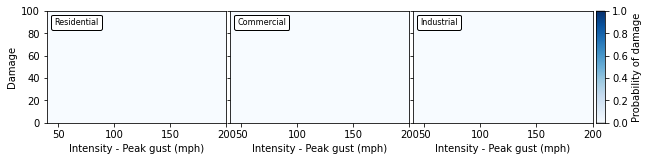

In [46]:
vulnerabilities_with_hazard_and_damage = vulnerabilities.merge(
    intensity_bin_dictionary, how='inner', 
    left_on='intensity_bin_id', right_on='bin_index').merge(
    damage_bin_dictionary, how='inner',
    suffixes=["_i", "_d"], left_on='damage_bin_id', right_on='bin_index')

fig = plt.figure(figsize=(10,20))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

vmin = 0.0
vmax = max(vulnerabilities_with_hazard_and_damage.probability)
labels = ["Residential", "Commercial", "Industrial"]
for idx, ax in enumerate(grid):
    a = np.zeros((29, 12))
    for index, row in vulnerabilities_with_hazard_and_damage[
        vulnerabilities_with_hazard_and_damage.vulnerability_id == idx + 1].iterrows():
        a[int(row.bin_index_i-1), 11-int(row.bin_index_d-1)] = row.probability
    
    im = ax.imshow(a, cmap=plt.cm.get_cmap('Blues'), vmin=vmin, vmax=vmax,
                   extent=(
                       min(intensity_bin_dictionary.interpolation), max(intensity_bin_dictionary.interpolation), 
                       min(damage_bin_dictionary.interpolation) * 100, max(damage_bin_dictionary.interpolation) * 100))

    at = AnchoredText(labels[idx],
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    ax.set_xlabel("Intensity - Peak gust (mph)")
    ax.set_ylabel("Damage")

grid[0].cax.colorbar(im)
cax = grid.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text("Probability of damage")

plt.show()

## 6 Exposure Analysis

To run the model we need some test exposure data. Lets have a look at an example Location and Account file. 

### 6.1 Locations

In [47]:
gdf_gar = omf.get_exposure(gar)

In [48]:
gdf_gar_location = omf.get_location(gdf_gar)

In [49]:
gdf_gar_occupancy = omf.lookup_occupancycode(gar_dictionary, gdf_gar_location)

In [50]:
test_locations = omf.convert_to_oasis_exposure(gdf_gar_occupancy, 
                                               PortNumber = 1,
                                               AccNumber= 'A11111',
                                               IsTenant = 1,
                                               BuildingID = 1,
                                               ConstructionCode = 5000,
                                               LocPerilsCovered = 'WTC',
                                               ContentsTIV = 0,
                                               BITIV = 0,
                                               CondNumber = 0,
                                               fp = fp_exp2
                                              )
print(" A csv of the Exposure dataframe in the oasis format has been saved into " + str(fp_exp2))
test_locations.head()

 A csv of the Exposure dataframe in the oasis format has been saved into ../tests/inputs/SourceLocOED.csv


,PortNumber,AccNumber,LocNumber,IsTenant,BuildingID,CountryCode,Latitude,Longitude,OccupancyCode,ConstructionCode,LocPerilsCovered,BuildingTIV,ContentsTIV,BITIV,CondNumber,PortNumber,LocCurrency
0,1,A11111,0,A11111,1,GLP,16.512500,-61.479167,1234,5000,WTC,1.91069,0,0,0,1,
1,1,A11111,1,A11111,1,GLP,16.470833,-61.520833,1234,5000,WTC,28.35320,0,0,0,1,
2,1,A11111,2,A11111,1,GLP,16.470833,-61.479167,1234,5000,WTC,57.82610,0,0,0,1,
3,1,A11111,3,A11111,1,GLP,16.470833,-61.437500,1234,5000,WTC,12.27960,0,0,0,1,
4,1,A11111,4,A11111,1,GLP,16.429167,-61.520833,1234,5000,WTC,44.53360,0,0,0,1,


### 6.2 Accounts

In [51]:
test_accounts = pd.read_csv('../tests/inputs/SourceAccOEDPiWind.csv')
test_accounts.head()

,PortNumber,PortName,PortNotes,AccNumber,AccName,AccGroup,AccStatus,ExpiringAccNumber,CedantName,AccCurrency,...,CondLimit3Contents,CondLimitCode4BI,CondLimitType4BI,CondLimit4BI,CondLimitCode5PD,CondLimitType5PD,CondLimit5PD,CondLimitCode6All,CondLimitType6All,CondLimit6All
0,1,0,0,A11111,0,0,0,0,0,GBP,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,A11111,0,0,0,0,0,GBP,...,0,0,0,0,0,0,0,0,0,0


## 7 Oasis Analysis

### 7.1 Analysis settings

To run the model, we also need to define some analysis settings. Lets have a look at an example settings file.

In [52]:
with open('../analysis_settings.json', 'r') as myfile:
    analysis_settings=json.loads(myfile.read().replace('\n', ''))
print(json.dumps(analysis_settings, indent=True))

{
 "analysis_tag": "base_example",
 "source_tag": "MDK",
 "model_version_id": "PiWind",
 "module_supplier_id": "OasisLMF",
 "number_of_samples": 10,
 "gul_threshold": 0,
 "gul_output": true,
 "model_settings": {
  "event_set": "p",
  "event_occurrence_id": "lt"
 },
 "gul_summaries": [
  {
   "aalcalc": true,
   "eltcalc": true,
   "id": 1,
   "lec_output": true,
   "leccalc": {
    "full_uncertainty_aep": true,
    "full_uncertainty_oep": true,
    "return_period_file": true
   }
  }
 ],
 "il_output": true,
 "il_summaries": [
  {
   "aalcalc": true,
   "eltcalc": true,
   "id": 1,
   "lec_output": true,
   "leccalc": {
    "full_uncertainty_aep": true,
    "full_uncertainty_oep": true,
    "return_period_file": true
   }
  }
 ],
 "ri_output": true,
 "ri_summaries": [
  {
   "aalcalc": true,
   "eltcalc": true,
   "id": 1,
   "lec_output": true,
   "leccalc": {
    "full_uncertainty_aep": true,
    "full_uncertainty_oep": true,
    "return_period_file": true
   }
  }
 ]
}


We can now run the model using the Oasis MDK.

### 7.2 Files to bin convertions and validation

First, convert the csv file into the required binary format; and then validate them: 

In [53]:
! evetobin < ../model_data/PiWind/events_p.csv > ../model_data/PiWind/events_p.bin

In [54]:
! footprinttobin -i 29 <../model_data/PiWind/footprint.csv

In [55]:
! validatefootprint < ../model_data/PiWind/footprint.csv

All checks pass.
Maximum value of intensity_bin_index = 19


In [56]:
! cp footprint.bin ../model_data/PiWind/ 
! cp footprint.idx ../model_data/PiWind/

In [57]:
! vulnerabilitytobin -d 11 < ../model_data/PiWind/vulnerability.csv > ../model_data/PiWind/vulnerability.bin

In [61]:
! validatevulnerability < ../model_data/PiWind/vulnerability.csv

All checks pass.  Please take note of any warnings.
Maximum value of damage_bin_index = 11


In [62]:
! occurrencetobin -P972 < ../model_data/PiWind/occurrence_lt.csv > ../model_data/PiWind/occurrence_lt.bin

In [63]:
! returnperiodtobin < ../model_data/PiWind/returnperiods.csv > ../model_data/PiWind/returnperiods.bin

In [64]:
! crossvalidation -d ../model_data/PiWind/damage_bin_dict.csv -f ../model_data/PiWind/footprint.csv -s ../model_data/PiWind/vulnerability.csv

Checking ../model_data/PiWind/vulnerability.csv ...
... Done.
Checking ../model_data/PiWind/footprint.csv ...
... Done.
Cross checks pass.


### 7.3 Run model

In [65]:
! rm -rf /tmp/analysis_test
! oasislmf model run -C ../oasislmf.json -r ../tests/outputs/analysis


Processing arguments - RunModel
RUNNING: oasislmf.manager.interface
  0%|                                                     | 0/2 [00:00<?, ?it/s]
Processing arguments - Creating Oasis Files

Generating Oasis files (GUL=True, IL=True, RIL=True)
RUNNING: oasislmf.lookup.rtree.get_vulnerabilities
Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.

Keys successful: /home/macab/OasisEvaluation/TestOasisEvaluation_GLP/Oasis_GLP/tests/outputs/analysis/input/keys.csv generated with 2060 items
Keys errors: /home/macab/OasisEvaluation/TestOasisEvaluation_GLP/Oasis_GLP/tests/outputs/analysis/input/keys-errors.csv generated with 0 items
RUNNING: oasislmf.preparation.gul_inputs.get_gul_input_items
RUNNING: oasislmf.preparation.summaries.write_exposure_summary
RUNNING: oasislmf.preparation.summaries.get_exposure_totals
RUNNING: oasislmf.preparation.summaries.get_exposure_summary_all
RUNNING: oasislmf.preparation.summa

### 7.4 Results

Lets visualize the output of our analysis.

<ipython-input-66-918dc818af71>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


Text(0, 0.5, 'Loss')

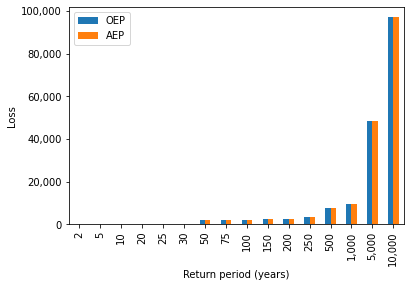

In [66]:
analysis_directory = "../tests/outputs/analysis"
gul_aep = pd.read_csv(os.path.join(analysis_directory, "output", "gul_S1_leccalc_full_uncertainty_aep.csv"))
gul_aep = gul_aep[gul_aep.type == 1]
gul_oep = pd.read_csv(os.path.join(analysis_directory, "output", "gul_S1_leccalc_full_uncertainty_oep.csv"))
gul_oep = gul_oep[gul_oep.type == 1]
eps = pd.merge(gul_oep, gul_aep, on=["summary_id", "return_period"], suffixes=["_oep", "_aep"])
eps = eps.sort_values(by="return_period", ascending=True)
fig, ax = plt.subplots()
eps.plot(ax=ax, kind='bar', x='return_period', y=["loss_oep", "loss_aep"])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xticklabels(['{:,}'.format(int(x)) for x in eps.return_period])
plt.legend(('OEP', 'AEP'))
ax.set_xlabel("Return period (years)")
ax.set_ylabel("Loss")